In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data prep
import missingno as msno
from sklearn.model_selection import train_test_split

# modelling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

RSEED = 394

In [4]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

## Size of data

In [10]:
df_train.shape

(30557, 82)

In [7]:
df_test.shape

(16136, 77)

## Which columns differ? 

In [13]:
diff_cols = [col for col in df_train.columns if col not in df_test.columns]
diff_cols

['target', 'target_min', 'target_max', 'target_variance', 'target_count']

## What are pollution-related and not pollution-related column? 

In [62]:
poll_cols = [col for col in df_train.columns if col.find('L3') != -1]
len(poll_cols)

other_colls = [col for col in df_train.columns if col.find('L3') == -1]
other_colls
poll_cols


['L3_NO2_NO2_column_number_density',
 'L3_NO2_NO2_slant_column_number_density',
 'L3_NO2_absorbing_aerosol_index',
 'L3_NO2_cloud_fraction',
 'L3_NO2_sensor_altitude',
 'L3_NO2_sensor_azimuth_angle',
 'L3_NO2_sensor_zenith_angle',
 'L3_NO2_solar_azimuth_angle',
 'L3_NO2_solar_zenith_angle',
 'L3_NO2_stratospheric_NO2_column_number_density',
 'L3_NO2_tropopause_pressure',
 'L3_NO2_tropospheric_NO2_column_number_density',
 'L3_O3_O3_column_number_density',
 'L3_O3_O3_effective_temperature',
 'L3_O3_cloud_fraction',
 'L3_O3_sensor_azimuth_angle',
 'L3_O3_sensor_zenith_angle',
 'L3_O3_solar_azimuth_angle',
 'L3_O3_solar_zenith_angle',
 'L3_CO_CO_column_number_density',
 'L3_CO_H2O_column_number_density',
 'L3_CO_cloud_height',
 'L3_CO_sensor_altitude',
 'L3_CO_sensor_azimuth_angle',
 'L3_CO_sensor_zenith_angle',
 'L3_CO_solar_azimuth_angle',
 'L3_CO_solar_zenith_angle',
 'L3_HCHO_HCHO_slant_column_number_density',
 'L3_HCHO_cloud_fraction',
 'L3_HCHO_sensor_azimuth_angle',
 'L3_HCHO_sensor

## What are different target variables? 

In [34]:
target_names = [col for col in df_train.columns if col.find('target') != -1]
target_names

target = df_train[target_names]
target.head()

,target,target_min,target_max,target_variance,target_count
0,38.0,23.0,53.0,769.50,92
1,39.0,25.0,63.0,1319.85,91
2,24.0,8.0,56.0,1181.96,96
3,49.0,10.0,55.0,1113.67,96
4,21.0,9.0,52.0,1164.82,95


In [41]:
loc_names = [col for col in df_train.columns if col.find('Place') != -1 or col.find('Date') != -1]
loc_names

['Place_ID X Date', 'Date', 'Place_ID']

## How many places and dates? 

In [75]:
df_train.Date.unique()
df_train.Date.nunique()

94

In [68]:
df_train.Place_ID.unique()
df_train.Place_ID.nunique()

340

In [69]:
94*340

31960

In [73]:
df_train.groupby('Place_ID').Place_ID.count().unique()

array([94, 90, 65, 92, 91, 93, 79, 82, 74, 49, 88, 80, 69, 73, 84,  3, 12,
       71, 68, 85, 89, 76, 41,  7, 86, 62, 29, 42, 48, 57, 70, 78])

In [70]:
len(df_train)

30557

## Split train and test

In [168]:
df = df_train.copy()

y = df[['target', 'Place_ID']]
X = df.drop(target_names, axis = 1)

loc = df[loc_names]

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED)

# define train and test, such that each city is in either or

# unique list of places
places = X.Place_ID.unique()
places

# split the cities into train and test
places_train, places_test = train_test_split(places, test_size=0.2, random_state=RSEED)

# filter the dataset for train and test cities
X_train = X[X['Place_ID'].isin(places_train)]
X_test = X[X['Place_ID'].isin(places_test)]

y_train = y[y['Place_ID'].isin(places_train)].drop('Place_ID', axis = 1)
y_test = y[y['Place_ID'].isin(places_test)].drop('Place_ID', axis = 1)

# display the shapes of train and test sets
print("Train Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)
print("Split percentage:", round(X_train.shape[0]/len(X)*100, 4), "%")

Train Set Shape: (24533, 77)
Test Set Shape: (6024, 77)
Split percentage: 80.286 %


In [163]:
y_train.describe()

count    22917.000000
mean        61.259153
std         47.183499
min          1.000000
25%         25.000000
50%         50.000000
75%         80.000000
max        815.000000
Name: target, dtype: float64

## Missing value inspection

In [111]:
X_train.isnull().sum()

Place_ID X Date                             0
Date                                        0
Place_ID                                    0
precipitable_water_entire_atmosphere        0
relative_humidity_2m_above_ground           0
                                        ...  
L3_CH4_aerosol_optical_depth            18570
L3_CH4_sensor_azimuth_angle             18570
L3_CH4_sensor_zenith_angle              18570
L3_CH4_solar_azimuth_angle              18570
L3_CH4_solar_zenith_angle               18570
Length: 77, dtype: int64

<Axes: >

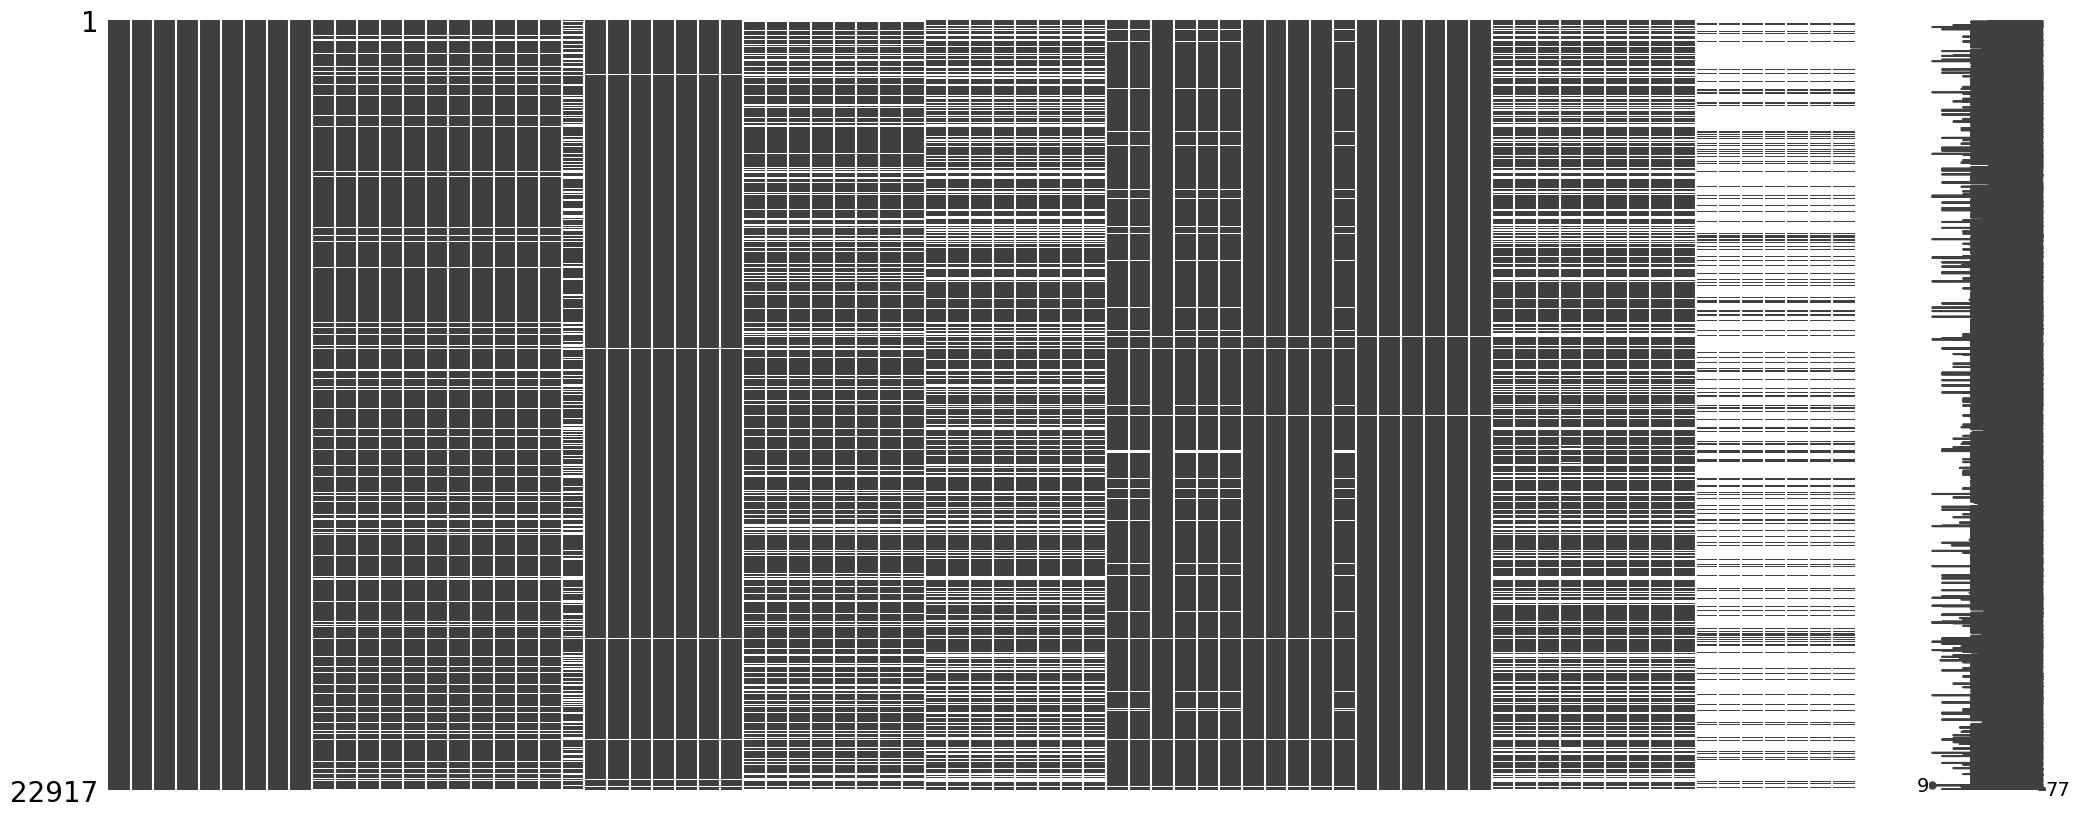

In [112]:
msno.matrix(X_train)

In [236]:
# msno.bar(X_train)

In [114]:
weather_cols = [col for col in X if col.find('L3') == -1]
weather_cols

['Place_ID X Date',
 'Date',
 'Place_ID',
 'precipitable_water_entire_atmosphere',
 'relative_humidity_2m_above_ground',
 'specific_humidity_2m_above_ground',
 'temperature_2m_above_ground',
 'u_component_of_wind_10m_above_ground',
 'v_component_of_wind_10m_above_ground']

In [115]:
# list_of_pollutants = [NO2, CH4, ....]

pollutants = list(set([pol.split('_')[1] for pol in X.columns if pol not in weather_cols and pol not in loc_names]))
pollutants = [pol + "_AI" if pol == "AER" else pol for pol in pollutants]

pollutants

['CO', 'HCHO', 'AER_AI', 'CLOUD', 'NO2', 'O3', 'CH4', 'SO2']

In [235]:
CH4_cols = [col for col in X.columns if col.find('CH4') != -1]
# msno.matrix(X[CH4_cols])

In [130]:
rep_list = ['L3_' + pol + '_solar_zenith_angle' for pol in pollutants]
rep_list
date = ['Date']

In [145]:
counts_missing = X.groupby('Place_ID')[rep_list + date].count().sort_values('L3_CH4_solar_zenith_angle')

counts_missing.head(5)

,L3_CO_solar_zenith_angle,L3_HCHO_solar_zenith_angle,L3_AER_AI_solar_zenith_angle,L3_CLOUD_solar_zenith_angle,L3_NO2_solar_zenith_angle,L3_O3_solar_zenith_angle,L3_CH4_solar_zenith_angle,L3_SO2_solar_zenith_angle,Date
Place_ID,,,,,,,,,
5IUK9TG,3,1,3,3,1,3,0,0,3
WY9VXCA,51,55,56,56,57,56,1,55,57
MJSB8K5,5,5,6,6,7,6,1,5,7
S91MBTB,17,14,28,28,28,29,1,17,29
SX68COZ,76,65,80,80,80,80,2,66,80


## Baseline model

- hypothesis: there is less PM2.5 in the atmosphere when it is windy
- method: OLS

- model
$$ y = b_0 + b_1 * x_1 + \epsilon $$

- estimated model
$$ PM_{2.5} = \hat{b}_0 + \hat{b}_1 * wind $$


In [176]:
weather_cols

['Place_ID X Date',
 'Date',
 'Place_ID',
 'precipitable_water_entire_atmosphere',
 'relative_humidity_2m_above_ground',
 'specific_humidity_2m_above_ground',
 'temperature_2m_above_ground',
 'u_component_of_wind_10m_above_ground',
 'v_component_of_wind_10m_above_ground']

In [226]:
base_features = ['relative_humidity_2m_above_ground']

base = LinearRegression()
base.fit(X_train[base_features], y_train)

y_pred_train = base.predict(X_train[base_features])
y_pred_base = base.predict(X_test[base_features])
e_base = y_test - y_pred_base

rmse = mean_squared_error(y_test, y_pred_base, squared = False)
rmse

r2 = r2_score(y_test, y_pred_base)
print(r2)

output = pd.DataFrame(np.c_[y_test, y_pred_base])
output

base.intercept_
base.coef_

r2_score(y_train, y_pred_train)


0.005368992639439574


0.0038451336599819586

Text(0, 0.5, 'pm2.5')

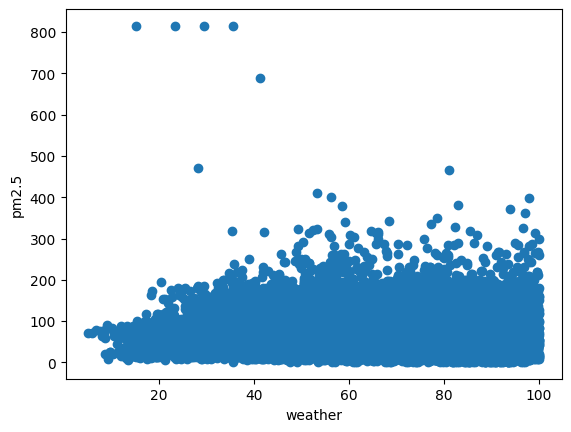

In [223]:
plt.scatter(X_train[base_features], y_train)
plt.xlabel('weather')
plt.ylabel('pm2.5')

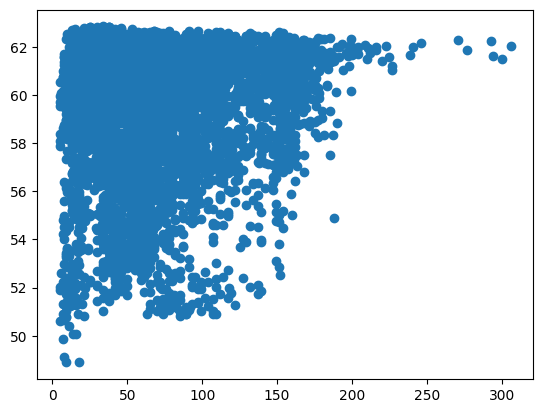

In [191]:
plt.scatter(y_test, y_pred_base)

## Imputation for missing values
- we decided to use linear interpolation on the level of a place. 
- This means we need to: 
    - order data by place and date
    - interpolate 

In [237]:
# X_train.columns

In [239]:
# drop all columns with satellite position information --> not relevant for prediction

useful_col = [col for col in X_train if col.find('sensor') == -1 and col.find('solar') == -1 ]
len(useful_col)
useful_col

X_train = X_train[useful_col]
X_test = X_test[useful_col]

# X_train.shape

(24533, 42)

In [251]:
# linear imputation of missing values
X_train.sort_values(['Place_ID X Date'])
X_test.sort_values(['Place_ID X Date'])

# Imputing with linear interpolation
linear_interpolation = X_train.interpolate(method='linear')
linear_interpolation.head()


linear_improved = X_train.groupby('Place_ID').apply(lambda group: group.interpolate(method='linear'))
linear_improved

## next: 
# 1. deal with corner values forward backward
# 2. deal with that one city which has 0 observations for CH4
# 3. plot results and celebrate

# # Plot imputed data
# linear_int['MaxSpeed'][:100].plot(color='red', marker='o', linestyle='dotted')
# df['MaxSpeed'][:100].plot(title='MaxSpeed', marker='o')

# splitting tasks: 
# - finish interpolation 
# - understand pollution variables & summary stastistics & correlations
# - scaling + feature engineering 
# - plan which model to use & implement 
# [- presentation]


Place_ID X Date        Date Place_ID   
Place_ID                                                    
010Q650  0      010Q650 X 2020-01-02  2020-01-02  010Q650  \
         1      010Q650 X 2020-01-03  2020-01-03  010Q650   
         2      010Q650 X 2020-01-04  2020-01-04  010Q650   
         3      010Q650 X 2020-01-05  2020-01-05  010Q650   
         4      010Q650 X 2020-01-06  2020-01-06  010Q650   
...                              ...         ...      ...   
YWSFY6Q  30552  YWSFY6Q X 2020-03-15  2020-03-15  YWSFY6Q   
         30553  YWSFY6Q X 2020-03-16  2020-03-16  YWSFY6Q   
         30554  YWSFY6Q X 2020-03-17  2020-03-17  YWSFY6Q   
         30555  YWSFY6Q X 2020-03-18  2020-03-18  YWSFY6Q   
         30556  YWSFY6Q X 2020-03-19  2020-03-19  YWSFY6Q   

                precipitable_water_entire_atmosphere   
Place_ID                                               
010Q650  0                                 11.000000  \
         1                                 14.600000   
         2                                 16.400000   
         3                                  6.911948   
         4                                 13.900001   
...                                              ...   
YWSFY6Q  30552                              6.700000   
         30553                              6.300000   
         30554                              7.100000   
         30555                             19.100000   
         30556                             11.600000   

                relative_humidity_2m_above_ground   
Place_ID                                            
010Q650  0                              60.200001  \
         1                              48.799999   
         2                              33.400002   
         3                              21.300001   
         4                              44.700001   
...                                           ...   
YWSFY6Q  30552                          68.300003   
         30553                          77.700005   
         30554                          68.500000   
         30555                          66.300003   
         30556                          68.400002   

                specific_humidity_2m_above_ground   
Place_ID                                            
010Q650  0                                0.00804  \
         1                                0.00839   
         2                                0.00750   
         3                                0.00391   
         4                                0.00535   
...                                           ...   
YWSFY6Q  30552                            0.00352   
         30553                            0.00341   
         30554                            0.00356   
         30555                            0.00523   
         30556                            0.00486   

                temperature_2m_above_ground   
Place_ID                                      
010Q650  0                        18.516840  \
         1                        22.546533   
         2                        27.031030   
         3                        23.971857   
         4                        16.816309   
...                                     ...   
YWSFY6Q  30552                     4.256799   
         30553                     2.067438   
         30554                     4.438623   
         30555                    10.573236   
         30556                     9.002069   

                u_component_of_wind_10m_above_ground   
Place_ID                                               
010Q650  0                                  1.996377  \
         1                                  3.330430   
         2                                  5.065727   
         3                                  3.004001   
         4                                  2.621787   
...                                              ...   
YWSFY6Q  30552                             -4.810586   
  